Index(['Timestamp', '1. What is your biggest reason for learning to code?',
       '2. What methods have you used to learn about coding? Please select all that apply.',
       '3. Which online learning resources have you found helpful? Please select all that apply.',
       '4. If you have attended in-person coding-related events before, which ones have you found helpful? Please select all that apply.',
       '5. If you have listened to coding-related podcasts before, which ones have you found helpful? Please select all that apply.',
       '6. If you have watched coding-related YouTube videos before, which channels have you found helpful? Please select all that apply.',
       '7. About how many hours do you spend learning each week?',
       '8. About how many months have you been programming?',
       '9. Aside from university tuition, about how much money have you spent on learning to code so far (in US Dollars)?',
       '10. Are you already employed in a software development job

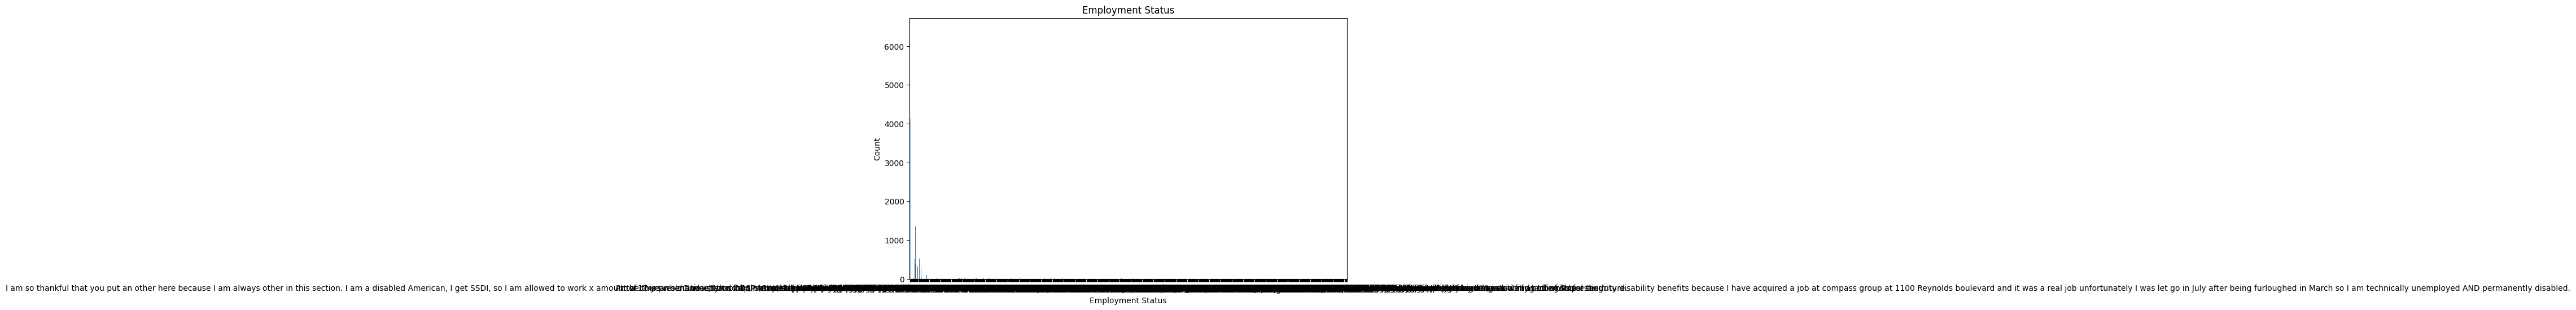

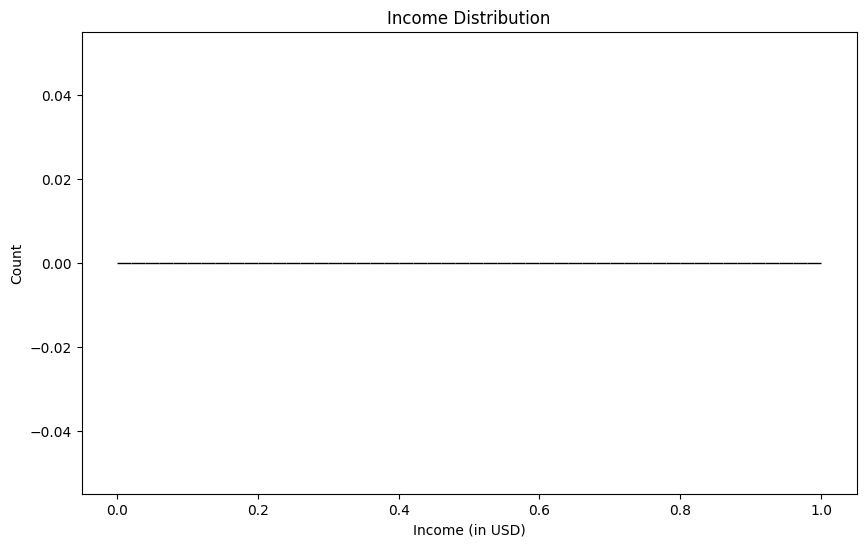

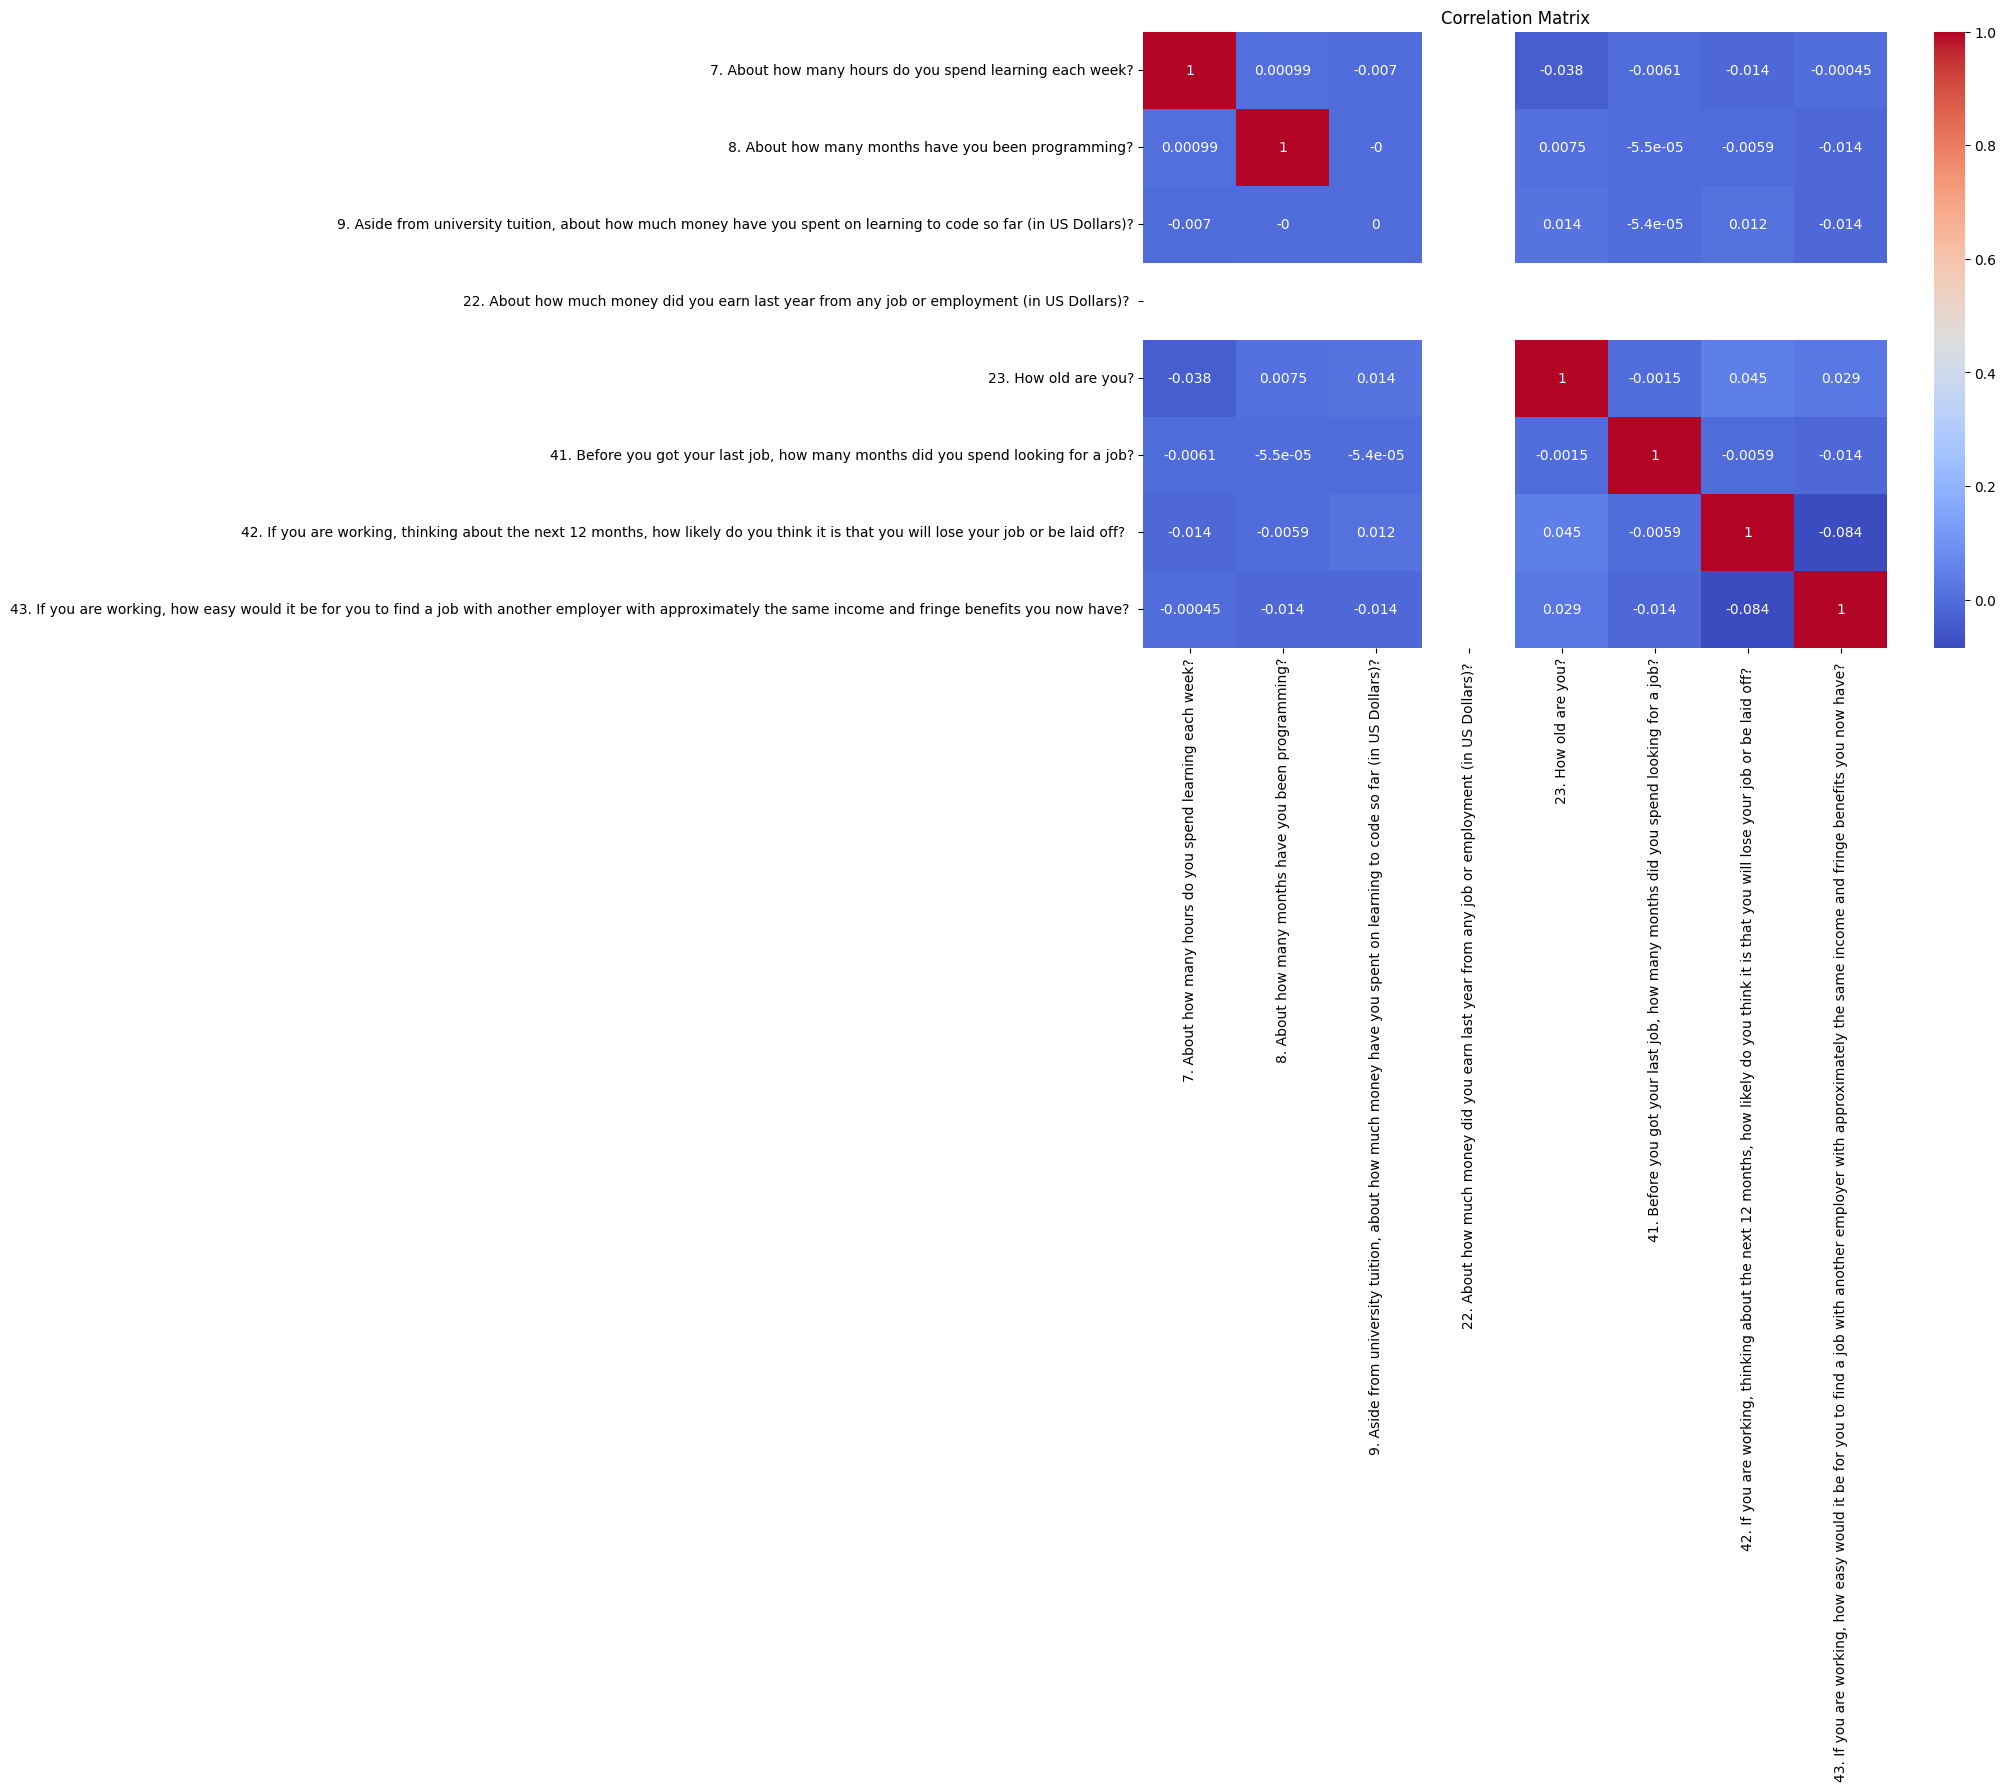

ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required by StandardScaler.

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Custom converter function to handle mixed data types
def convert_to_float(x):
    try:
        return float(x.replace(',', '').replace('$', ''))
    except ValueError:
        return np.nan

# Load the dataset with specified converters to handle mixed types
data = pd.read_csv(
    r"D:\Users\Downloads\2021 New Coder Survey.csv\2021 New Coder Survey.csv",
    converters={
        '7. About how many hours do you spend learning each week?': convert_to_float,
        '8. About how many months have you been programming?': convert_to_float,
        '9. Aside from university tuition, about how much money have you spent on learning to code so far (in US Dollars)?': convert_to_float,
        '22. About how much money did you earn last year from any job or employment (in US Dollars)? ': convert_to_float
    }
)

# Print column names to inspect and correct
print(data.columns)

# Correct column name after inspection
employment_status_col = '20. Regarding employment status, are you currently.... '
income_col = '22. About how much money did you earn last year from any job or employment (in US Dollars)? '

# Convert timestamp to datetime
data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')

# Fill missing values for numeric columns
numeric_cols = data.select_dtypes(include=[np.number]).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())

# Fill missing values for non-numeric columns
non_numeric_cols = data.select_dtypes(exclude=[np.number]).columns
for col in non_numeric_cols:
    data[col] = data[col].fillna(data[col].mode()[0])

# EDA: Visualizations
plt.figure(figsize=(10, 6))
sns.countplot(x=data[employment_status_col])
plt.title('Employment Status')
plt.xlabel('Employment Status')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data[income_col], bins=50, kde=True)
plt.title('Income Distribution')
plt.xlabel('Income (in USD)')
plt.ylabel('Count')
plt.show()

# Calculate and visualize correlation matrix for numeric columns only
plt.figure(figsize=(12, 8))
numeric_data = data[numeric_cols]  # Extract only numeric columns
corr_matrix = numeric_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Cluster Analysis
cluster_features = ['7. About how many hours do you spend learning each week?', 
                    '8. About how many months have you been programming?', 
                    income_col]

# Standardize the features
scaler = StandardScaler()
data_clustering = data[cluster_features].dropna()
data_clustering_scaled = scaler.fit_transform(data_clustering)

# Determine the optimal number of clusters using the elbow method
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(data_clustering_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# Fit KMeans with the optimal number of clusters (e.g., k=3)
optimal_k = 3  # Change based on elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(data_clustering_scaled)
data['Cluster'] = pd.Series(clusters, index=data_clustering.index)

# PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(data_clustering_scaled)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=data.loc[data_clustering.index, 'Cluster'], palette='viridis')
plt.title('Cluster Visualization with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# Classification
data['HighIncome'] = data[income_col] >= 30000

classification_features = ['7. About how many hours do you spend learning each week?', 
                           '8. About how many months have you been programming?', 
                           '9. Aside from university tuition, about how much money have you spent on learning to code so far (in US Dollars)?', 
                           '10. Are you already employed in a software development job?', 
                           employment_status_col]

X = data[classification_features].dropna()
y = data.loc[X.index, 'HighIncome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}

for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print(f'{model_name} Accuracy: {accuracy_score(y_test, y_pred):.2f}')
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print('---')

rf = models['RandomForest']
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. feature {classification_features[indices[f]]} ({importances[indices[f]]})")

plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [classification_features[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()
